In [6]:
import os
import pandas as pd
import re

In [19]:

main_dir = './conf_matrix__dropout_autolr_trlayers_NoAug'

In [21]:

import os
import pandas as pd
import re

def parse_model_characteristics(folder_name):
    pattern = r"a(\d+)_([\d\.]+)fps_(\d+)bs_([\d\.]+)lr_confusion_([\d\.]+)dr_(\d+)tl"
    match = re.match(pattern, folder_name)
    if match:
        return {
            "Epoch": f"A{match.group(1)}",
            "FPS": float(match.group(2)),
            "BS": int(match.group(3)),
            "LR": float(match.group(4)),
            "DR": float(match.group(5)),
            "Tr_layers": int(match.group(6))
        }
    return {}

def parse_metrics(file_content):
    lines = file_content.strip().split('\n')
    metrics = {}
    for line in lines:
        if 'Precision' in line:
            continue
        if 'Accuracy' in line or 'Loss' in line:
            key, value = line.split(':')
            metrics[key.strip().replace(' ', '_')] = float(value.strip())
        else:
            parts = line.split()
            if len(parts) == 5:
                label = parts[0]
                metrics[f"Precision_{label}"] = float(parts[1])
                metrics[f"Recall_{label}"] = float(parts[2])
                metrics[f"F1_{label}"] = float(parts[3])
    return metrics

all_data = []

for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    if os.path.isdir(folder_path):
        characteristics = parse_model_characteristics(folder_name)
        
        # Assuming the metrics file is named 'classification_metrics.txt' in each subfolder
        metrics_file_path = os.path.join(folder_path, 'classification_metrics.txt')
        if os.path.isfile(metrics_file_path):
            with open(metrics_file_path, 'r') as file:
                file_content = file.read()
            metrics = parse_metrics(file_content)
            
            data = {**characteristics, **metrics}
            all_data.append(data)

# Combine all data into a single DataFrame
final_df = pd.DataFrame(all_data)

# Save to CSV or any preferred format
final_df.to_csv('model_performance_metrics.csv', index=False)



# Hiperparameter Analysis

In [1]:
import pandas as pd

# Cargando el archivo CSV para revisar su contenido y estructura
file_path = './model_performance_metrics.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas del archivo y un resumen de la estructura de los datos
data_info = data.info()
data_head = data.head()

(data_info, data_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Modelo              34 non-null     object 
 1   FPS                 34 non-null     float64
 2   BS                  34 non-null     int64  
 3   LR                  34 non-null     float64
 4   DR                  34 non-null     float64
 5   Tr_layers           34 non-null     int64  
 6   Precision_Fight     34 non-null     float64
 7   Recall_Fight        34 non-null     float64
 8   F1_Fight            34 non-null     float64
 9   Precision_No_Fight  34 non-null     float64
 10  Recall_No_Fight     34 non-null     float64
 11  F1_No_Fight         34 non-null     float64
 12  Test_Accuracy       34 non-null     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 3.6+ KB


(None,
   Modelo  FPS  BS     LR   DR  Tr_layers  Precision_Fight  Recall_Fight  \
 0     A0  5.0  32  0.001  0.2          2           0.7251        0.8095   
 1     A0  5.0  32  0.001  0.2          3           0.7440        0.8148   
 2     A0  5.0  32  0.001  0.3          0           0.7215        0.8360   
 3     A0  5.0  32  0.001  0.4          2           0.7487        0.7566   
 4     A0  5.0  64  0.001  0.1          2           0.7397        0.8571   
 
    F1_Fight  Precision_No_Fight  Recall_No_Fight  F1_No_Fight  Test_Accuracy  
 0    0.7650              0.7844           0.6931       0.7360         0.7672  
 1    0.7778              0.7953           0.7196       0.7556         0.7593  
 2    0.7745              0.8050           0.6772       0.7356         0.7646  
 3    0.7526              0.7540           0.7460       0.7500         0.7593  
 4    0.7941              0.8302           0.6984       0.7586         0.7619  )

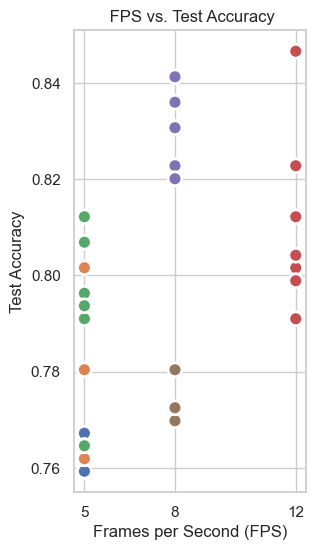

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de visualizaciones
sns.set(style="whitegrid")

# Preparación de gráficos
# Filtrar datos para incluir solo FPS con valores 5, 8, y 12
filtered_data = data[data['FPS'].isin([5, 8, 12])]
marker_dict = {model: 'x' for model in filtered_data['Modelo'].unique()}

# Crear el gráfico ajustado
fig, ax = plt.subplots(figsize=(3, 6))
sns.scatterplot(data=filtered_data, x='FPS', y='Test_Accuracy', hue='Modelo',markers=marker_dict, s=100 , linewidth=2, ax=ax)
ax.set_title(' FPS vs. Test Accuracy')
ax.set_xlabel('Frames per Second (FPS)')
ax.set_ylabel('Test Accuracy')
ax.set_xticks([5, 8, 12])  # Ajustar ticks del eje X
ax.legend_.remove()  # Eliminar la leyenda
plt.show()


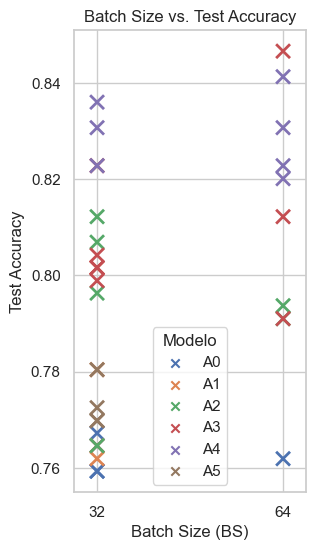

In [37]:
# Filtrar datos para incluir solo BS con valores 32 y 64
bs_filtered_data = data[data['BS'].isin([32, 64])]
marker_dict = {model: 'x' for model in bs_filtered_data['Modelo'].unique()}
# Ajuste del gráfico con cruces más gruesas
fig, ax = plt.subplots(figsize=(3, 6))
# Incrementar el grosor del marcador
sns.scatterplot(data=bs_filtered_data, x='BS', y='Test_Accuracy', hue='Modelo', style='Modelo', markers=marker_dict, s=100, ax=ax, linewidth=2)

ax.set_title('Batch Size vs. Test Accuracy')
ax.set_xlabel('Batch Size (BS)')
ax.set_ylabel('Test Accuracy')
ax.set_xticks([32, 64])  # Ajustar ticks del eje X
ax.set_xlim(28, 68)  # Ajustar límites del eje X para reducir espacio
plt.show()


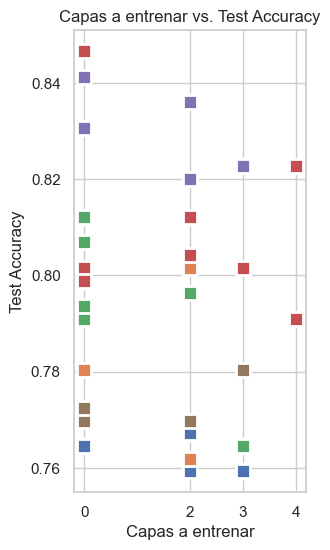

In [50]:
# Filtrar datos para incluir solo BS con valores 32 y 64
marker_dict = {model: 's' for model in data['Modelo'].unique()}
# Ajuste del gráfico con cruces más gruesas
fig, ax = plt.subplots(figsize=(3, 6))
# Incrementar el grosor del marcador
sns.scatterplot(data=data, x='Tr_layers', y='Test_Accuracy', hue='Modelo', style='Modelo', markers=marker_dict, s=100, ax=ax, linewidth=2)

ax.set_title('Capas a entrenar vs. Test Accuracy')
ax.set_xlabel('Capas a entrenar')
ax.set_ylabel('Test Accuracy')
ax.set_xticks([0, 2,3,4]) 
ax.legend_.remove()
plt.show()


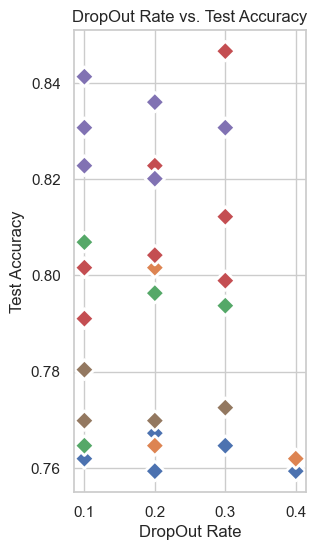

In [53]:
# Filtrar datos para incluir solo BS con valores 32 y 64
marker_dict = {model: 'D' for model in data['Modelo'].unique()}
# Ajuste del gráfico con cruces más gruesas
fig, ax = plt.subplots(figsize=(3, 6))
# Incrementar el grosor del marcador
sns.scatterplot(data=data, x='DR', y='Test_Accuracy', hue='Modelo', style='Modelo', markers=marker_dict, s=100, ax=ax, linewidth=2)

ax.set_title('DropOut Rate vs. Test Accuracy')
ax.set_xlabel('DropOut Rate')
ax.set_ylabel('Test Accuracy')
ax.legend_.remove()
plt.show()

In [54]:

# Calculando las desviaciones estándar para cada métrica de evaluación agrupadas por modelo
new_std_metrics = data.groupby('Modelo').agg({
    'Precision_Fight': 'std',
    'Recall_Fight': 'std',
    'F1_Fight': 'std',
    'Precision_No_Fight': 'std',
    'Recall_No_Fight': 'std',
    'F1_No_Fight': 'std',
    'Test_Accuracy': 'std'
}).reset_index()

new_std_metrics

,Modelo,Precision_Fight,Recall_Fight,F1_Fight,Precision_No_Fight,Recall_No_Fight,F1_No_Fight,Test_Accuracy
0,A0,0.011915,0.037597,0.015415,0.027951,0.026622,0.010821,0.003440
1,A1,0.026426,0.040376,0.020580,0.027357,0.035468,0.017821,0.018243
2,A2,0.019995,0.032693,0.019552,0.029866,0.029121,0.020489,0.016591
3,A3,0.037974,0.048578,0.017962,0.030932,0.057015,0.022685,0.017595
4,A4,0.018932,0.024215,0.010653,0.021071,0.028402,0.013062,0.007766
5,A5,0.008559,0.027099,0.010056,0.017679,0.018863,0.004246,0.005014


In [59]:
data['FPS'] = data['FPS'].astype('category')
data['BS'] = data['BS'].astype('category')
data['LR'] = data['LR'].astype('category')
data['DR'] = data['DR'].astype('category')
data['Tr_layers'] = data['Tr_layers'].astype('category')


In [62]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

# Función para realizar ANOVA y recolectar p-values
def perform_anova(data, factors, metrics):
    results = pd.DataFrame(index=factors, columns=metrics)
    for metric in metrics:
        for factor in factors:
            model = ols(f'{metric} ~ C({factor})', data=data).fit()
            anova_results = sm.stats.anova_lm(model, typ=2)
            p_value = anova_results['PR(>F)'][0]  # Extraer el p-value
            results.loc[factor, metric] = p_value
    return results

# Lista de hiperparámetros y métricas
factors = ['FPS', 'BS', 'LR', 'DR', 'Tr_layers']
metrics = ['Precision_Fight', 'Recall_Fight', 'F1_Fight', 'Precision_No_Fight', 'Recall_No_Fight', 'F1_No_Fight', 'Test_Accuracy']

# Ejecutando ANOVA
anova_results = perform_anova(data, factors, metrics)


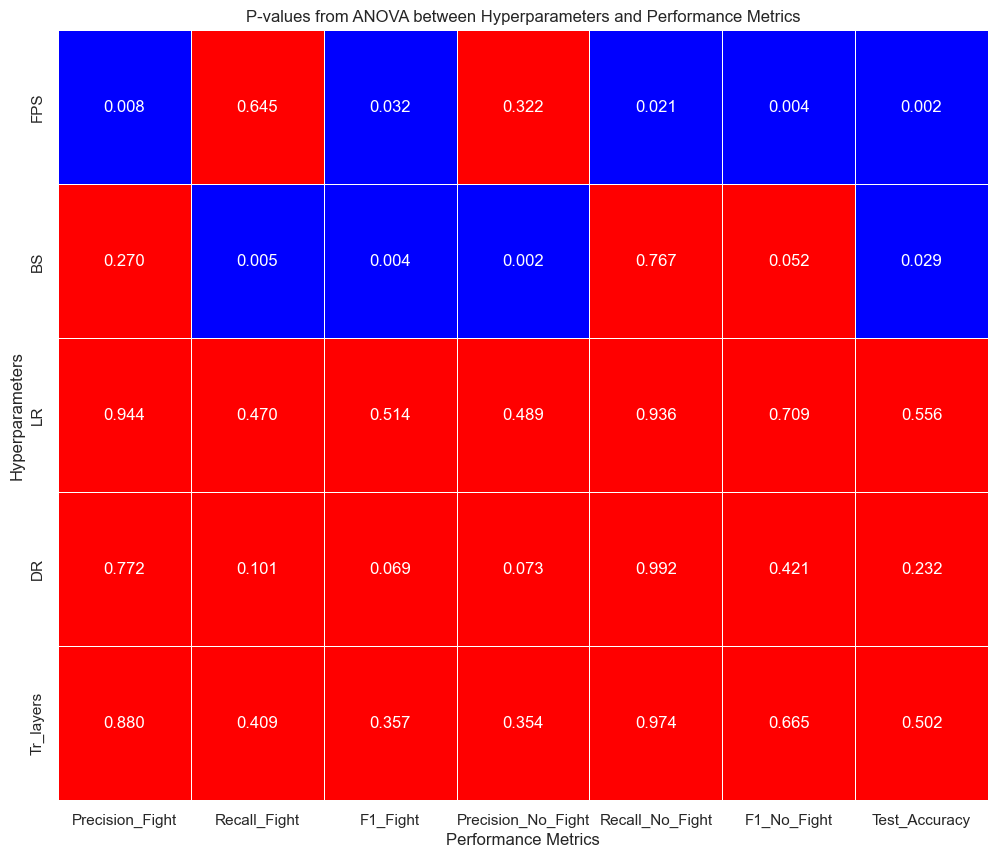

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap  # Importar ListedColormap

# Convertir los p-values a float para visualización
anova_results = anova_results.astype(float)

# Definir una función para crear una paleta de colores basada en la significancia
def significance_palette(data, threshold=0.05, color_sig='blue', color_not_sig='red'):
    # Crear una paleta que solo tiene dos colores basados en la significancia
    return np.where(data <= threshold, color_sig, color_not_sig)

# Crear un array de colores basado en la significancia de los p-values
palette = significance_palette(anova_results, 0.05, 'blue', 'red')

# Crear el mapa de calor usando la paleta de colores condicionales
plt.figure(figsize=(12, 10))
sns.heatmap(anova_results, annot=True, mask=anova_results > 0.05, cmap=ListedColormap(['blue']), cbar=False, fmt=".3f", linewidths=.5)
sns.heatmap(anova_results, annot=True, mask=anova_results <= 0.05, cmap=ListedColormap(['red']), cbar=False, fmt=".3f", linewidths=.5)
plt.title('P-values from ANOVA between Hyperparameters and Performance Metrics')
plt.xlabel('Performance Metrics')
plt.ylabel('Hyperparameters')
plt.show()
